In [ ]:
!pip install opencv-python

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.6 MB/s eta 0:00:00


In [ ]:
!pip install seaborn

Cloning into 'yolov5'...
remote: Enumerating objects: 17757, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 17757 (delta 73), reused 39 (delta 39), pack-reused 17635 (from 3)
Receiving objects: 100% (17757/17757), 17.15 MiB | 23.14 MiB/s, done.
Resolving deltas: 100% (12055/12055), done.
Loading model from /content/drive/MyDrive/ADSP_project/yolov5m_people_crowd.pt...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/content/yolov5/models/common.py:898: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Ground truth: 29 People
Count: 28 People


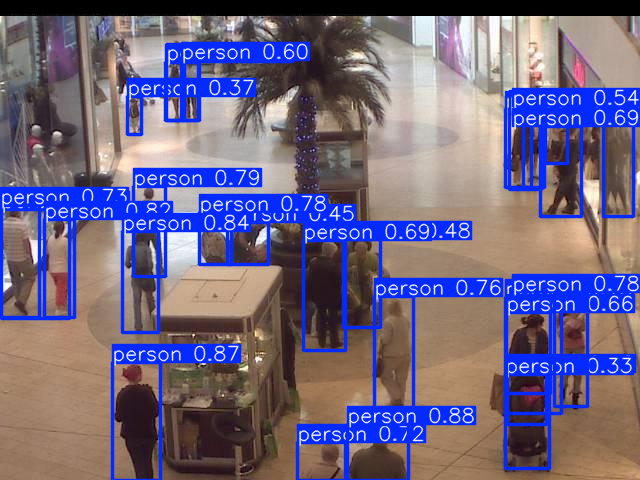

In [ ]:
import torch
import cv2
import numpy as np
import pathlib
import os
import sys
from google.colab.patches import cv2_imshow

if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5


sys.path.append('/content/yolov5')


MODEL_PATH = "/content/drive/MyDrive/ADSP_project/yolov5m_people_crowd.pt"
IMAGE_PATH = "/content/drive/MyDrive/ADSP_project/seq_000001.jpg"

if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: '{MODEL_PATH}' not found. Please upload it.")
else:
    print(f"Loading model from {MODEL_PATH}...")


    model = torch.load(MODEL_PATH, weights_only=False)

    if not os.path.exists(IMAGE_PATH):
        print(f"❌ Error: '{IMAGE_PATH}' not found. Please upload it.")
    else:
        results = model(IMAGE_PATH)

        output_image_rgb = np.squeeze(results.render())
        output_image_bgr = cv2.cvtColor(output_image_rgb, cv2.COLOR_RGB2BGR)

        print("Ground truth: 29 People")
        print(f"Count: {len(results.xyxy[0])} People")
        cv2_imshow(output_image_bgr)


In [ ]:
import torch
import cv2
import numpy as np
import pathlib
import os
import sys
import pandas as pd
import warnings
from google.colab.patches import cv2_imshow

warnings.filterwarnings("ignore")
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5
sys.path.append('/content/yolov5')

temp = pathlib.WindowsPath
pathlib.WindowsPath = pathlib.PosixPath

MODEL_PATH = "/content/drive/MyDrive/ADSP_project/yolov5m_people_crowd.pt"
INPUT_VIDEO = "/content/drive/MyDrive/ADSP_project/sample_video.mp4"
OUTPUT_VIDEO = "/content/drive/MyDrive/ADSP_project/output_processed.mp4"
OUTPUT_CSV = "/content/drive/MyDrive/ADSP_project/occupancy_data.csv"

if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: Model '{MODEL_PATH}' not found.")
else:
    print(f"Loading model from {MODEL_PATH}...")
    model = torch.load(MODEL_PATH, weights_only=False)

    model.conf = 0.25
    model.iou = 0.45

    cap = cv2.VideoCapture(INPUT_VIDEO)

    if not cap.isOpened():
        print(f"❌ Error: Could not open video '{INPUT_VIDEO}'. Check filename!")
    else:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps    = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video Info: {width}x{height} at {fps} FPS ({total_frames} frames)")

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (width, height))

        frame_data = []
        frame_idx = 0

        print("Processing video... this may take a while.")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = model(img_rgb)

            count = len(results.xyxy[0])
            frame_data.append({"Frame": frame_idx, "Count": count})

            render_img = results.render()[0]

            out_frame = cv2.cvtColor(render_img, cv2.COLOR_RGB2BGR)

            cv2.putText(out_frame, f"Occupancy: {count}", (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)

            out.write(out_frame)
            if frame_idx % 50 == 0:
                print(f"Processed frame {frame_idx}/{total_frames} | Count: {count}")

            frame_idx += 1

        cap.release()
        out.release()

        df = pd.DataFrame(frame_data)
        df.to_csv(OUTPUT_CSV, index=False)

        print("\n✅ processing Complete!")
        print(f"1. Video saved to: {OUTPUT_VIDEO}")
        print(f"2. CSV Data saved to: {OUTPUT_CSV}")

        pathlib.WindowsPath = temp

Loading model from /content/drive/MyDrive/ADSP_project/yolov5m_people_crowd.pt...
Video Info: 640x360 at 25 FPS (341 frames)
Processing video... this may take a while.
Processed frame 0/341 | Count: 30
Processed frame 50/341 | Count: 27
Processed frame 100/341 | Count: 29
Processed frame 150/341 | Count: 28
Processed frame 200/341 | Count: 29
Processed frame 250/341 | Count: 28
Processed frame 300/341 | Count: 30

✅ processing Complete!
1. Video saved to: output_processed.mp4
2. CSV Data saved to: occupancy_data.csv
